In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt 
from tqdm import tqdm
import time 

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



Using device: cpu


In [2]:
print("Loading dataset...")
data = np.load('../data/synthetic_tracking_dataset.npz', allow_pickle=True)
videos = data['videos']
positions = data['positions']

print(f"✓ Loaded {len(videos)} videos")
print(f"✓ Video shape: {videos.shape}")
print(f"✓ Each video has {videos.shape[1]} frames")

Loading dataset...
✓ Loaded 1000 videos
✓ Video shape: (1000, 50, 32, 32)
✓ Each video has 50 frames


In [3]:
class TrackingDataset(Dataset):
    """
    Dataset for tracking task.
    Given two consecutive frames, predict the position in the second frame.
    """
    def __init__(self, videos, positions):
        self.videos = videos
        self.positions = positions

    def __len__(self):
        return len(self.videos) * (self.videos.shape[1] - 1)

    def __getitem__(self, idx):

        video_idx = idx // (self.videos.shape[1] - 1)
        frame_idx = idx % (self.videos.shape[1] - 1)

        frame1 = self.videos[video_idx, frame_idx]
        frame2 = self.videos[video_idx, frame_idx + 1]

        input_frames = np.stack([frame1, frame2], axis=0)

        target_pos = np.array(self.positions[video_idx][frame_idx + 1])

        input_frames = torch.FloatTensor(input_frames)
        target_pos = torch.FloatTensor(target_pos)

        return input_frames, target_pos

print("Creating dataset...")
full_dataset = TrackingDataset(videos, positions)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size]
)

print(f"✓ Training samples: {len(train_dataset)}")
print(f"✓ Validation samples: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_input, test_target = next(iter(train_loader))
print(f"n✓ Batch input shape: {test_input.shape}")
print(f"✓ Batch target shape: {test_target.shape}")
        

    

Creating dataset...
✓ Training samples: 39200
✓ Validation samples: 9800
n✓ Batch input shape: torch.Size([32, 2, 32, 32])
✓ Batch target shape: torch.Size([32, 2])


In [4]:
class PatchEmbedding(nn.Module):
    """Convert image into patches and embed them"""
    def __init__(self, img_size=32, patch_size=4, in_channels=2, embed_dim=64):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size

        self.proj = nn.Conv2d( #convulational layer that extractes and embeds patches
            in_channels, embed_dim,
            kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1,2)
        return x

class StandardAttention(nn.Module):
    """Standard multi-head self-attention"""
    def __init__(self, dim, num_heads=4, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape #unpack the input shape

        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim) #creates qkv
        qkv = qkv.permute(2, 0, 3, 1, 4) #organize for multi-head attention
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale #compare patches - where you get the attentions scores
        attn = attn.softmax(dim=-1) #convert to probabilities
        attn = self.dropout(attn) #prevents overfitting

        x = (attn @ v).transpose(1, 2).reshape(B, N, C) #apply attention weights to values
        x = self.proj(x) # refine output 

        return x

class TransformerBlock(nn.Module):
    """One transformer block: Attention + MLP"""
    def __init__(self, dim, num_heads=4, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = StandardAttention(dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(dim)

        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(), #activation function
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))

        x = x + self.mlp(self.norm2(x))
        return x

print("✓ Model components defined!")

✓ Model components defined!


In [5]:
class VisionTransformerTracker(nn.Module):
    """
    Vision Transformer for tracking.
    Takes two frames, outputs predicted (x, y) position.
    """

    def __init__(
        self,
        img_size=32,
        patch_size=4,
        in_channels=2,
        embed_dim=64,
        depth=4, #transformer blocks
        num_heads=4, 
        mlp_ratio=4,
        dropout=0.1
    ):
        super().__init__()

        self.patch_embed = PatchEmbedding(
            img_size, patch_size, in_channels, embed_dim
        )
        num_patches = self.patch_embed.num_patches

        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim)) #tensors become paramters
        self.dropout = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim) # stabilises numbers for final prediction head

        self.head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2), # compresses dims, 64 to 32
            nn.GELU(), #adds non-linearity
            nn.Linear(embed_dim // 2, 2) #returns two coordinates for prediction from 32 dims
        )

    def forward(self, x):

        x = self.patch_embed(x)

        x = x + self.pos_embed
        x = self.dropout(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        x = x.mean(dim=1)

        pos = self.head(x)

        return pos

print("Creating model...")
model = VisionTransformerTracker(
    img_size=32,
    patch_size=4,
    embed_dim=64,
    depth=4,
    num_heads=4
).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"✓ Model created with {total_params:,} parameters")

test_input = torch.randn(4, 2, 32, 32).to(device)
test_output = model(test_input)
print(f"✓ Test output shape: {test_output.shape}")


Creating model...
✓ Model created with 208,418 parameters
✓ Test output shape: torch.Size([4, 2])


In [6]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """ Train for one epoch """
    model.train # puts model in training mode, dropout is turned on
    total_loss = 0

    for inputs, targets in tqdm(dataloader, desc="Training"):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad() #clear old gradients since they accumulate
        outputs = model(inputs)
        loss = criterion(outputs, targets) #calculates how far off the model was the real answers

        loss.backward() #checks how much each weight contributed to loss
        optimizer.step() #updates weight using gradients

        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    """ Validate the model"""
    model.eval() # puts model in evaluation mode, dropout is turned off
    total_loss = 0

    with torch.no_grad(): #turns off tracking for gradient and no updating weights
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()

    return total_loss / len(dataloader)

print("✓ Training functions defined!")
    

✓ Training functions defined!


Starting training...


Training: 100%|█████████████████████████████| 1225/1225 [00:40<00:00, 30.60it/s]


Epoch 1/20
 Train Loss: 30.7239
 Val Loss: 0.5431
 LR: 0.000994
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:24<00:00, 50.15it/s]


Epoch 2/20
 Train Loss: 0.2116
 Val Loss: 0.2119
 LR: 0.000976
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:24<00:00, 50.02it/s]


Epoch 3/20
 Train Loss: 0.1305
 Val Loss: 0.1444
 LR: 0.000946
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:24<00:00, 50.10it/s]


Epoch 4/20
 Train Loss: 0.1057
 Val Loss: 0.1178
 LR: 0.000905
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:24<00:00, 49.90it/s]


Epoch 5/20
 Train Loss: 0.0770
 Val Loss: 0.0795
 LR: 0.000854
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:24<00:00, 49.91it/s]


Epoch 6/20
 Train Loss: 0.0677
 Val Loss: 0.0879
 LR: 0.000794
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:24<00:00, 50.19it/s]


Epoch 7/20
 Train Loss: 0.0594
 Val Loss: 0.0932
 LR: 0.000727
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:24<00:00, 49.85it/s]


Epoch 8/20
 Train Loss: 0.0464
 Val Loss: 0.0439
 LR: 0.000655
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:24<00:00, 49.87it/s]


Epoch 9/20
 Train Loss: 0.0406
 Val Loss: 0.0633
 LR: 0.000578
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:24<00:00, 49.91it/s]


Epoch 10/20
 Train Loss: 0.0386
 Val Loss: 0.0337
 LR: 0.000500
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:23<00:00, 52.84it/s]


Epoch 11/20
 Train Loss: 0.0308
 Val Loss: 0.0257
 LR: 0.000422
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:24<00:00, 49.99it/s]


Epoch 12/20
 Train Loss: 0.0255
 Val Loss: 0.0230
 LR: 0.000345
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:24<00:00, 50.13it/s]


Epoch 13/20
 Train Loss: 0.0229
 Val Loss: 0.0226
 LR: 0.000273
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:24<00:00, 49.72it/s]


Epoch 14/20
 Train Loss: 0.0207
 Val Loss: 0.0176
 LR: 0.000206
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:24<00:00, 49.54it/s]


Epoch 15/20
 Train Loss: 0.0177
 Val Loss: 0.0228
 LR: 0.000146
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:24<00:00, 49.59it/s]


Epoch 16/20
 Train Loss: 0.0155
 Val Loss: 0.0141
 LR: 0.000095
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:24<00:00, 49.01it/s]


Epoch 17/20
 Train Loss: 0.0140
 Val Loss: 0.0137
 LR: 0.000054
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:25<00:00, 48.56it/s]


Epoch 18/20
 Train Loss: 0.0128
 Val Loss: 0.0131
 LR: 0.000024
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:24<00:00, 49.18it/s]


Epoch 19/20
 Train Loss: 0.0118
 Val Loss: 0.0122
 LR: 0.000006
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:24<00:00, 49.67it/s]


Epoch 20/20
 Train Loss: 0.0112
 Val Loss: 0.0116
 LR: 0.000000
------------------------------------------------------------

✓ Training completed!


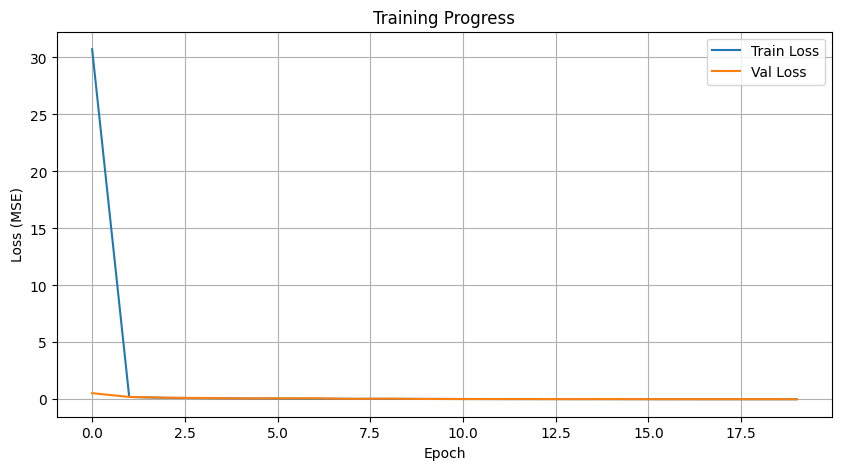

In [7]:
criterion = nn.MSELoss() #MSE is mean squared errors, benefits - smooth gradient, 
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01) #updating weights with Adam W algo and weight decay, lr = learning rate which can't be too big or too small, former causes too much loss and the latter causes learning to slow to a crawl
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

num_epochs = 20
train_losses = []
val_losses = []

print("Starting training...")
print("=" * 60)

for epoch in range(num_epochs):

    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    val_loss = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f" Train Loss: {train_loss:.4f}")
    print(f" Val Loss: {val_loss:.4f}")
    print(f" LR: {scheduler.get_last_lr()[0]:.6f}")
    print("-" * 60)
    

print("\n✓ Training completed!")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label="Val Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
def calculate_accuracy(model, dataloader, device, threshold=2.0):
    """
    Calculate tracking accuracy.
    Threshold: How many pixels away is considered "correct"
    """
    model.eval()
    total_error = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            distances = torch.sqrt(((outputs - targets) ** 2).sum(dim=1)) #Euclidean distance
            total_error += distances.sum().item()
            correct += (distances < threshold).sum().item()
            total += len(distances)

    avg_error = total_error / total
    accuracy = (correct / total) * 100

    return avg_error, accuracy

print("Calculating accuracy...")
avg_error, accuracy = calculate_accuracy(model, val_loader, device)
print(f"\n✓ Average Position Error: {avg_error:.2f} pixels")
print(f"✓  Accuracy (within 2 pixels): {accuracy:.2f}%")
    
            

Calculating accuracy...

✓ Average Position Error: 0.13 pixels
✓  Accuracy (within 2 pixels): 100.00%
